In [1]:
!pip install gymnasium pygame mediapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.8 MB/s eta 0:00:00


# Imports

In [2]:
import numpy as np
import pygame
import gymnasium as gym
from gymnasium import spaces
import mediapy as media
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

pygame 2.6.1 (SDL 2.28.4, Python 3.11.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Markov Decision Processes
We here consider a very simple example of a discrete Markov Decision Process (MDP) in that an agent (blue circle) wants to reach a destination (red square) in the least amount of time possible. Upon reaching the goal, the agent receives a reward and the episode ends. The agent can be located on any one of the 16 fields, minus the goal location, since the process ends as soon as the agent reaches the goal. So the agent can be in one of 15 discrete states. In every step, the agent can decide in which direction it wants to move. This kind of MDP is often called grid-world.

We formalize this as the MDP $\langle\mathcal{S},\mathcal{A},R,P,\gamma\rangle$, where:,
*  $\mathcal{S}$ is a set of _states_ that the agent inhabits. You can also consider continuous state spaces, but for this notebook we will only be considering the finite kind.,
*  $\mathcal{A}$ is a set of _actions_ that the agent can perform from each state. In the vast majority of cases, it is assumed that all actions are available in all states. Action spaces can also be continuous, but we will be limiting ourselves to finite action spaces in this notebook.,
*  $R:\mathcal{S}\times\mathcal{A}\rightarrow [R_{min}, R_{max}]\subset\mathbb{R}$ is a bounded reward (or cost) function which provides the agent with (positive or negative) reinforcement.,
*  $P:\mathcal{S}\times\mathcal{A}\rightarrow\Delta(\mathcal{S})$ encodes the transition dynamics, where $P(s, a)(s')$ is the probability of ending in state $s'$ after taking action $a$ from state $s$.,
*  $\gamma\in[0, 1)$ is a discount factor.,

The notation $\Delta(X)$ stands for the set of probability distributions over a set $X$.

Since the discount factor $\gamma$ is strictly less than $1$, it encourages the agent to accumulate rewards as quickly as possible. In our example above, it means the optimal policy is also the shortest path to the goal.

The agent interacts with the environment in discrete time steps. If at time step $t$ the agent is in state $s_t$ and chooses action $a_t$, the environment responds with a new state $s_{t+1}\sim P(s_t, a_t)$ and a reward $R(s_t, a_t)$.,

We here implement our MDP as a OpenAI Gym environment, which comes with a set of abstract methods that have to be implemented, most importantly: reset() and step().

In [3]:
# We here code the simple MDP. When reading the code you can skip the rendering part.
# Adapted from https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/
class GridWorldEnv(gym.Env):

    action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

    def __init__(self):
        self.size = 4  # The size of the square grid
        self.window_size = 256  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)

    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}

    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            )
        }

    def reset(self, seed=None, target=None):
        super().reset(seed=seed)

        if target is None:
            # Choose the target's location uniformly at random
            self._target_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        else:
            assert len(target) == 2
            self._target_location = np.array(target)

        # We will sample the agent's location randomly until it does not coincide with the target's location
        self._agent_location = self._target_location
        while np.array_equal(self._agent_location, self._target_location):
            self._agent_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self.action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        # An episode is done if the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = 1 if terminated else 0  # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, info

    def render(self, action=None):
        return self._render_frame(action)

    def _render_frame(self, action):
        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )
        if action is not None:
            pygame.draw.line(
                canvas,
                1,
                (self._agent_location + 0.5) * pix_square_size,
                (self._agent_location + 0.5 + self.action_to_direction[action]/3) * pix_square_size,
                width=2
            )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        return np.transpose(
            np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
        )

In [4]:
## Main
# Lets try this with a randomly acting agent (so there is no state-dependance of the policy).
# Note that the video stops at the last encountered state which is a state next to the goal,
# in that an action is executed that takes the agent to the goal location.
env = GridWorldEnv()
frames = []
target = (3,3)
observation = env.reset(target=target)
rewards = []
for t in range(500):
    action = env.action_space.sample()
    frames.append(env.render(action))
    observation, reward, done, info = env.step(action)
    rewards.append(reward)
    if done:
        print(f"Episode finished after {t+1} timesteps. Cummulative return: {sum(rewards)}")
        break

media.show_video(frames, fps=5, loop=False)

Episode finished after 32 timesteps. Cummulative return: 1


### Tasks:
1. The cummulative return of the run was 1 no matter how long the episode took. Why is this not great? What can we do against it? Code this.

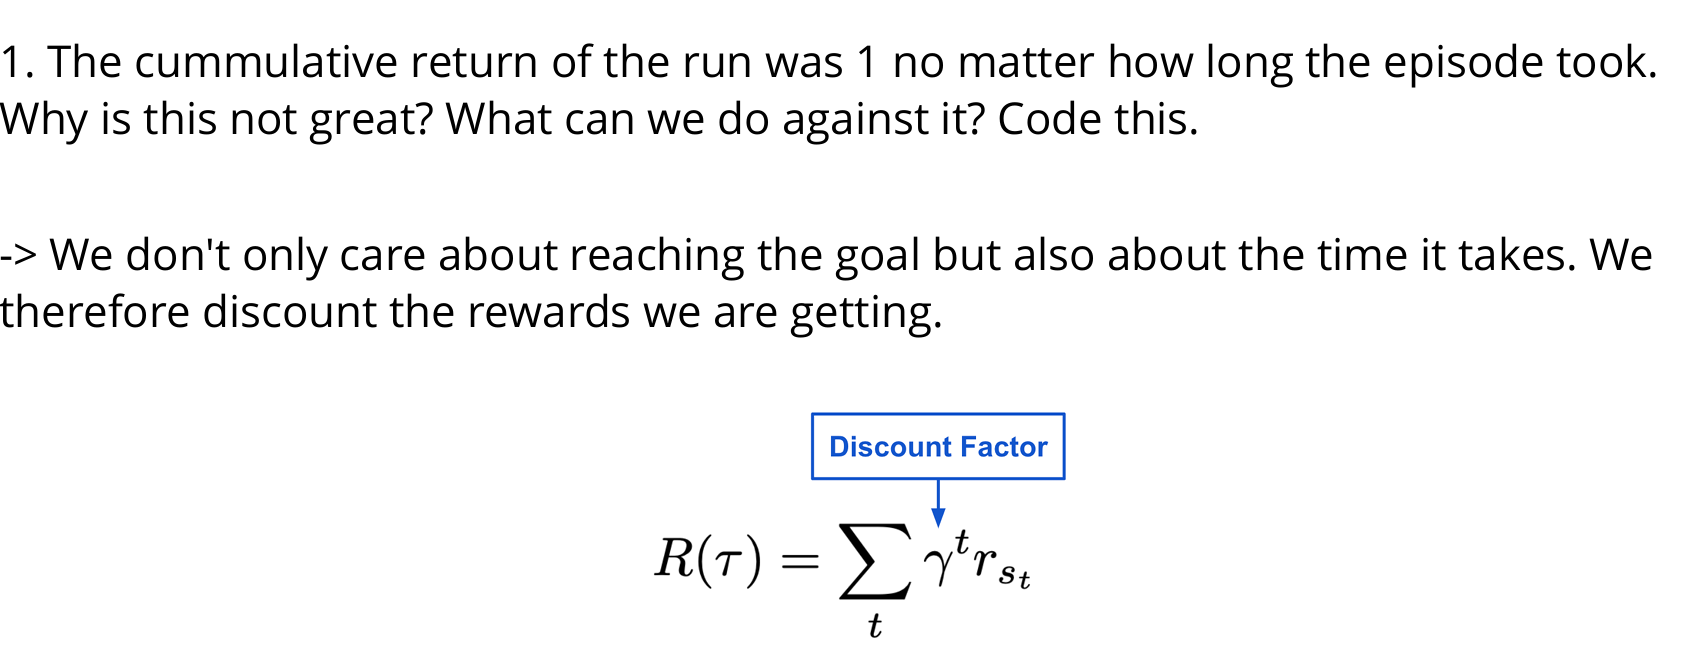

**Changes Made**

- **Dense Reward:**
Reward = (prev_distance - new_distance) * 0.1 - 0.1 for non-terminal steps. +1 reward when reaching the target.
Encourages moving closer to the target and penalizes each step.

- **Fixed Discounted Return:**
Replaced np.cumprod(len(rewards)*[gamma]) with np.array([gamma**t for t in range(len(rewards))]).
Correctly computes
[
𝛾
0
,
𝛾
1
,
…
,
𝛾
𝑇
−
1
]
[γ
0
 ,γ
1
 ,…,γ
T−1
 ] for the dot product.

**The cumulative return is always 1 because the reward is sparse (1 only when the target is reached, 0 otherwise).**

In [5]:
## Solution
# Lets try this with a randomly acting agent (so there is no state-dependance of the policy).
# Note that the video stops at the last encountered state which is a state next to the goal,
# in that an action is executed that takes the agent to the goal location.
env = GridWorldEnv()
frames = []
target = (3,3)
observation = env.reset(target=target)
rewards = []
gamma = 0.9
for t in range(500):
    action = env.action_space.sample()
    frames.append(env.render(action))
    observation, reward, done, info = env.step(action)
    rewards.append(reward)
    if done:
        np.cumprod(len(rewards)*[gamma])
        discounted_return = np.dot(np.cumprod(len(rewards)*[gamma]),np.array(rewards))
        print(f"Episode finished after {t+1} timesteps. Discounted cummulative return: {discounted_return}")
        break

media.show_video(frames, fps=5, loop=False)

Episode finished after 16 timesteps. Discounted cummulative return: 0.1853020188851842


In [6]:
from gym import spaces

class GridWorldEnv(gym.Env):
    action_to_direction = {
        0: np.array([1, 0]),
        1: np.array([0, 1]),
        2: np.array([-1, 0]),
        3: np.array([0, -1]),
    }

    def __init__(self):
        self.size = 4
        self.window_size = 256
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
            }
        )
        self.action_space = spaces.Discrete(4)

    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}

    def _get_info(self):
        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}

    def reset(self, seed=None, target=None):
        super().reset(seed=seed)
        if target is None:
            self._target_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        else:
            self._target_location = np.array(target)
        self._agent_location = self._target_location
        while np.array_equal(self._agent_location, self._target_location):
            self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        return self._get_obs(), self._get_info()

    def step(self, action):
        prev_distance = np.linalg.norm(self._agent_location - self._target_location, ord=1)
        direction = self.action_to_direction[action]
        self._agent_location = np.clip(self._agent_location + direction, 0, self.size - 1)
        new_distance = np.linalg.norm(self._agent_location - self._target_location, ord=1)
        terminated = np.array_equal(self._agent_location, self._target_location)
        if terminated:
            reward = 1
        else:
            reward = (prev_distance - new_distance) * 0.1 - 0.1  # Distance-based + step penalty
        observation = self._get_obs()
        info = self._get_info()
        return observation, reward, terminated, info

    # Render methods (skipped for brevity, unchanged)
    def render(self, action=None):
        return self._render_frame(action)

    def _render_frame(self, action):
        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = self.window_size / self.size
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )
        if action is not None:
            pygame.draw.line(
                canvas,
                1,
                (self._agent_location + 0.5) * pix_square_size,
                (self._agent_location + 0.5 + self.action_to_direction[action]/3) * pix_square_size,
                width=2
            )
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )
        return np.transpose(
            np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
        )

# Main loop with corrected discounted return
env = GridWorldEnv()
frames = []
target = (3, 3)
observation, info = env.reset(target=target)
rewards = []
gamma = 0.9
for t in range(500):
    action = env.action_space.sample()
    frames.append(env.render(action))
    observation, reward, done, info = env.step(action)
    rewards.append(reward)
    if done:
        discounts = np.array([gamma**t for t in range(len(rewards))])
        discounted_return = np.dot(discounts, np.array(rewards))
        print(f"Episode finished after {t+1} timesteps. Discounted cumulative return: {discounted_return:.2f}")
        break

media.show_video(frames, fps=5, loop=False)

Episode finished after 79 timesteps. Discounted cumulative return: -0.80


# Computing Policies and Value Functions with Dynamic Programming
Polcies define how agents act. Usually they are a function that maps from a state (or observation in the case of partial observability) to a distribution over possible actions to execute. We typically denote this $\pi(a|s)$. Note that the policy can be stochastic or deterministic. In the previous example, we used a random policy, that does not base its actions on the state.

State-value functions define the expected value, that is the cummulative sum of (discounted) future rewards, of being in a particular state. Of course, in general this value depends on the policy that we use. We denote this $V^\pi(s)$. Of course, without discounting in the previous example the cummulative future reward is $V^\pi(s) = 1$.

The value of a state is recursively defined by the values of the states that can be reached in one timestep, weighted by the probability of going to this state. This probability is defined both by the transition dynamics and the followed policy.

$V^{\pi}(s) = \mathbb{E}_{a\sim\pi(s)}\left[R(s, a) + \gamma\mathbb{E}_{s'\sim P(s, a)}[V^{\pi}(s')]\right]$

For now we use a very simple uniform random policy that does not depend on the state, so $\pi(a|s) = \frac{1}{|\mathcal{A}|}, \forall a \in \mathcal{A}$

In [7]:
## Main
# Since we know the full MDP, we can use dynamic programming (a fixed-point algorithm) to get the value function.
# Note that we could also use other methods like solving a set of linear equations.
policy = lambda s: [0.25,0.25,0.25,0.25] # our random policy, it does not depend on the state
gamma = 0.9 # discount factor
target = (3,3)
directions = np.array([[1,0],[0,1],[-1,0],[0,-1]])
V = np.zeros((4,4)) # (col, row), starting top left
for steps in range(200):
    # Iteration over states
    for state_idx in range(16):
        state = (state_idx%4,int(state_idx/4))
        if state==target:
            continue
        action_probs = policy(state)
        assert sum(action_probs) == 1.
        subseq_states = np.clip(state+directions,0,3)
        values_subseq_states = np.array([V[tuple(idx)] for idx in subseq_states])
        rewards = (subseq_states==target).all(1).astype('float')
        # Expectation over the action space (note that our transition dynamics are deterministic
        # so we do not have to average over it.)
        V[state] = np.sum(action_probs*(rewards+gamma*values_subseq_states))

print(f'State-Values for the given policy:\n{np.round(V.T,2)}')

State-Values for the given policy:
[[0.07 0.09 0.11 0.14]
 [0.09 0.11 0.17 0.23]
 [0.11 0.17 0.29 0.47]
 [0.14 0.23 0.47 0.  ]]


### Tasks
1. We have set a gamma value of 0.9. Play around with it. What happens if you set it to 0?
2. We here have uniform random policy. Play around with it. What happens if you change it to a state-independent, deterministic policy?
3. We have computed the state-value function. In many cases, we use the state-action value function, often called Q-function: $Q^{\pi}(s, a) = R(s, a) + \gamma\mathbb{E}_{s'\sim P(s, a)}[V^{\pi}(s')]$. This function tells us how much discounted future reward we can expect when executing action a in state s and following the policy $\pi$ after. Change the code above to also compute the Q-function.

In [8]:
## Q1:  We have set a gamma value of 0.9. Play around with it. What happens if you set it to 0?


# Since we know the full MDP, we can use dynamic programming (a fixed-point algorithm) to get the value function.
# Note that we could also use other methods like solving a set of linear equations.
policy = lambda s: [0.25,0.25,0.25,0.25] # our random policy, it does not depend on the state
gamma = 0 # discount factor
target = (3,3)
directions = np.array([[1,0],[0,1],[-1,0],[0,-1]])
V = np.zeros((4,4)) # (col, row), starting top left
for steps in range(200):
    # Iteration over states
    for state_idx in range(16):
        state = (state_idx%4,int(state_idx/4))
        if state==target:
            continue
        action_probs = policy(state)
        assert sum(action_probs) == 1.
        subseq_states = np.clip(state+directions,0,3)
        values_subseq_states = np.array([V[tuple(idx)] for idx in subseq_states])
        rewards = (subseq_states==target).all(1).astype('float')
        # Expectation over the action space (note that our transition dynamics are deterministic
        # so we do not have to average over it.)
        V[state] = np.sum(action_probs*(rewards+gamma*values_subseq_states))

print(f'State-Values for the given policy:\n{np.round(V.T,2)}')

State-Values for the given policy:
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.25]
 [0.   0.   0.25 0.  ]]


**The value function V only considers immediate rewards, ignoring future rewards.**

**If gamma were 0.9, values would propagate to states further from the target, reflecting discounted future rewards, resulting in a more distributed value function.**


In [9]:
## Q2: We here have uniform random policy. Play around with it. What happens if you change it to a state-independent, deterministic policy?

policy = lambda s: [1,0,0,0] # Deterministic policy: always move right
gamma = 0 # discount factor
target = (3,3)
directions = np.array([[1,0],[0,1],[-1,0],[0,-1]])
V = np.zeros((4,4)) # (col, row), starting top left
for steps in range(200):
    # Iteration over states
    for state_idx in range(16):
        state = (state_idx%4,int(state_idx/4))
        if state==target:
            continue
        action_probs = policy(state)
        assert sum(action_probs) == 1.
        subseq_states = np.clip(state+directions,0,3)
        values_subseq_states = np.array([V[tuple(idx)] for idx in subseq_states])
        rewards = (subseq_states==target).all(1).astype('float')
        # Expectation over the action space (note that our transition dynamics are deterministic
        # so we do not have to average over it.)
        V[state] = np.sum(action_probs*(rewards+gamma*values_subseq_states))

print(f'State-Values for the given policy:\n{np.round(V.T,2)}')

State-Values for the given policy:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]]


In [10]:
## Q3:  We have computed the state-value function. In many cases, we use the state-action value function, often called Q-function:  Qπ(s,a)=R(s,a)+γEs′∼P(s,a)[Vπ(s′)] .
## This function tells us how much discounted future reward we can expect when executing action a in state s and following the policy  π  after. Change the code above to also compute the Q-function.


## Solution
# Since we know the full MDP, we can use dynamic programming (fixed-point algorithm) to get the value function.
# Note that we could also use other methods like solving a set of linear equations.
policy = lambda s: [0.25,0.25,0.25,0.25] # our random policy, it does not depend on the state
gamma = 0.9 # discount factor
target = (3,3)
directions = np.array([[1,0],[0,1],[-1,0],[0,-1]])
V_pi = np.zeros((4,4)) # (col, row), starting top left
Q_pi = np.zeros((4,4,4))  # The dimensions are (column, row, action), where the last dimension corresponds to the four actions (0: right, 1: up, 2: left, 3: down).
for steps in range(200):
    # Iteration over states
    for state_idx in range(16):
        state = (state_idx%4,int(state_idx/4))
        if state==target:
            continue
        action_probs = policy(state)
        assert sum(action_probs) == 1.
        subseq_states = np.clip(state+directions,0,3)
        V_subseq_states = np.array([V_pi[tuple(idx)] for idx in subseq_states])
        rewards = (subseq_states==target).all(1).astype('float')
        # Expectation over the action space (note that our transition dynamics are deterministic
        # so we do not have to average over it.)
        V_pi[state] = np.sum(action_probs*(rewards+gamma*V_subseq_states))
        Q_pi[state] = rewards + gamma * V_subseq_states

print(f'State-Values for the given policy:\n{np.round(V_pi.T,3)}')
print(f'State-action-value function for going right and then following the policy:\n{np.round(Q_pi[:,:,0].T,3)}')

State-Values for the given policy:
[[0.071 0.087 0.114 0.139]
 [0.087 0.114 0.167 0.226]
 [0.114 0.167 0.287 0.471]
 [0.139 0.226 0.471 0.   ]]
State-action-value function for going right and then following the policy:
[[0.078 0.103 0.125 0.125]
 [0.103 0.15  0.203 0.203]
 [0.15  0.258 0.424 0.424]
 [0.203 0.424 1.    0.   ]]


# Acting Optimally
The goal in reinforcement learning is to find a policy that maximizes the discounted future return that the agent can expect. In other words, we want to find a policy $\pi^*$ that dominates all other policies: $V^* := V^{\pi^*} \geq V^{\pi}$ for all $\pi$. It turns out that there is always at least one policy that achieves the optimum. The Bellman optimality equations express this via the recurrence:

$V^*(s) = \max_{a\in\mathcal{A}}\left[R(s, a) + \gamma\sum_{s'\in\mathcal{S}} P(s, a)(s')V^*(s')\right]$

The state-action value function can be defined in a similar way as above:
        
$Q^*(s, a) = R(s, a) + \gamma\mathbb{E}_{s'\sim P(s, a)}[V^*(s')]$
        
Once we know $Q^*$ we can find a deterministic $\pi^*(s)$ via:
        
$\pi^*(s) = \arg\max_{a\in\mathcal{A}}Q^*(s, a)$

We can obtain V* and Q* by an algorithm called value iteration, that repeatedly applies the Bellman optimility equation to all states/state-action pairs.

In [12]:
# Since we know the full MDP, we can use dynamic programming (fixed-point algorithm) to get the value function.
# Note that we could also use other methods like solving a set of linear equations.
policy = lambda s: [0.25,0.25,0.25,0.25] # our random policy, it does not depend on the state
gamma = 0.9 # discount factor
target = (3,3)
directions = np.array([[1,0],[0,1],[-1,0],[0,-1]])
V_star = np.zeros((4,4)) # (col, row), starting top left
Q_star = np.zeros((4,4,4))
for steps in range(200):
    # Iteration over states
    for state_idx in range(16):
        state = (state_idx%4,int(state_idx/4))
        if state==target:
            continue
        action_probs = policy(state)
        assert sum(action_probs) == 1.
        subseq_states = np.clip(state+directions,0,3)
        V_subseq_states = np.array([V_star[tuple(idx)] for idx in subseq_states])
        rewards = (subseq_states==target).all(1).astype('float')
        V_star[state] = np.max(rewards+gamma*V_subseq_states)
        Q_star[state] = rewards + gamma * V_subseq_states

print(f'Optimal state-values:\n{np.round(V_star.T,3)}')
print(f'Optimal state-action-value function for going right:\n{np.round(Q_star[:,:,0].T,3)}')
dir_str = lambda idxs: np.array(list(map(lambda i: ['right','down','left','right'][i], idxs)))
print(f'The optimal policy (there exist multiple optimal policies):\
      \n{np.array(dir_str(np.argmax(Q_star,axis=2).T.reshape(-1))).reshape(4,4)}')

Optimal state-values:
[[0.59  0.656 0.729 0.81 ]
 [0.656 0.729 0.81  0.9  ]
 [0.729 0.81  0.9   1.   ]
 [0.81  0.9   1.    0.   ]]
Optimal state-action-value function for going right:
[[0.59  0.656 0.729 0.729]
 [0.656 0.729 0.81  0.81 ]
 [0.729 0.81  0.9   0.9  ]
 [0.81  0.9   1.    0.   ]]
The optimal policy (there exist multiple optimal policies):      
[['right' 'right' 'right' 'down']
 ['right' 'right' 'right' 'down']
 ['right' 'right' 'right' 'down']
 ['right' 'right' 'right' 'right']]


In [13]:
# Lets record some episodes with the optimal policy
env = GridWorldEnv()
frames = []
target = (3,3)
for episode in range(5):
	s = env.reset(target=target)[0]['agent']
	for t in range(500):
		action = np.argmax(Q_star[tuple(s)])
		frames.append(env.render(action))
		s, r, terminal, info = env.step(action)  # s = The next state (observation dictionary). r = The reward (1 if the target (3,3) is reached, 0 otherwise). terminal = A boolean indicating if the episode has ended (True if the target is reached). info = Additional information (not used here).
		s = s['agent']
		if terminal:
			break
media.show_video(frames, fps=5, loop=True)  # Displays the collected frames as a video with 5 frames per second, looping continuously. This visualizes the agent’s movement across all episodes.

### Tasks:
1. How do V* and Q* relate? As we know, $Q^*(s, a) = R(s, a) + \gamma\mathbb{E}_{s'\sim P(s, a)}[V^*(s')]$. How can you get V* from Q*? Code it and confirm that it is the same as our computed V*.

In [14]:
## Solution
V_from_Q = np.max(Q_star,axis=2)
print((V_star==V_from_Q).all())

True


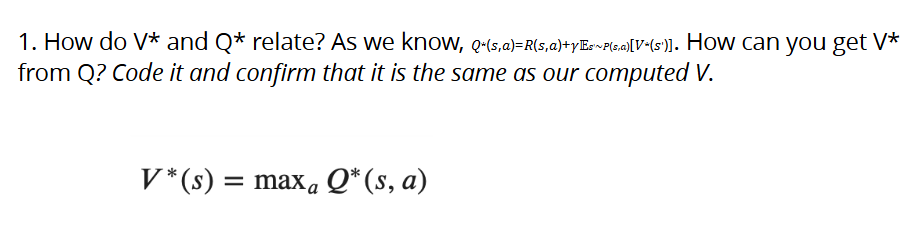

In [15]:
# Compute V* from Q* by taking the maximum over actions
V_from_Q = np.max(Q_star, axis=2)  # Max over action dimension (index 2)

# Print V* derived from Q*
print(f"V* computed from Q*:\n{np.round(V_from_Q.T, 3)}")

# Assume V_star is the precomputed V* (e.g., from value iteration)
# For confirmation, print precomputed V*
print(f"Precomputed V*:\n{np.round(V_star.T, 3)}")

# Check if they match
if np.allclose(V_from_Q, V_star):
    print("V* from Q* matches precomputed V*.")
else:
    print("V* from Q* does NOT match precomputed V*.")

V* computed from Q*:
[[0.59  0.656 0.729 0.81 ]
 [0.656 0.729 0.81  0.9  ]
 [0.729 0.81  0.9   1.   ]
 [0.81  0.9   1.    0.   ]]
Precomputed V*:
[[0.59  0.656 0.729 0.81 ]
 [0.656 0.729 0.81  0.9  ]
 [0.729 0.81  0.9   1.   ]
 [0.81  0.9   1.    0.   ]]
V* from Q* matches precomputed V*.


# Learning V* and Q* from data from Monte Carlo Samples
So far we have used the Bellman Optimality Equation and our exact knowledge of R and P to compute V and Q. However, in the real world, we usually do not have access to these functions. In addition, we usually have many states and actions to choose from, in the continuous case even an infinite amount. What we usually do have is an environment to interact with, so that we can try out what happens when we execute different actions. This where reinforcement learning comes in. It leverages data that we obtain from trying around to learn the optimal policy.

One possible approach is Monte Carlo simulation, which estimates the value of actions or states through sampling full episodes. In this approach, an agent learns by interacting with an environment, collecting trajectories, and updating its policy based on the observed rewards. Monte Carlo methods sample multiple episodes of experience to approximate the expected return, enabling the agent to make informed decisions about which actions to take in a given state.

The state value function of a given state under a policy $\pi$ is then the average return that was obtained when starting in that state:

$V^\pi(s) \approx \frac{1}{N(s)} \sum_{i=1}^{N(s)} G_i$,

where $G_i$ is the obtained discounted episode return. $Q^\pi$ is defined analogously.

We will here use an expsilon-greedy Q-policy. The policy is therefore changing over the course of our trial. We thus use an update equation:

$V(s) \leftarrow (1-\alpha) \cdot V(s) + \alpha \cdot G_i$,

where $\alpha$ is called the learning rate.

In our example the difference between dynamic programming and learning from data might seem minimal because we have coded the environment ourselves. But it is in fact a fundamental one. We could use the following methods for environments that we have absolutely no knowledge about.

Text(0, 0.5, 'avg. episode length')

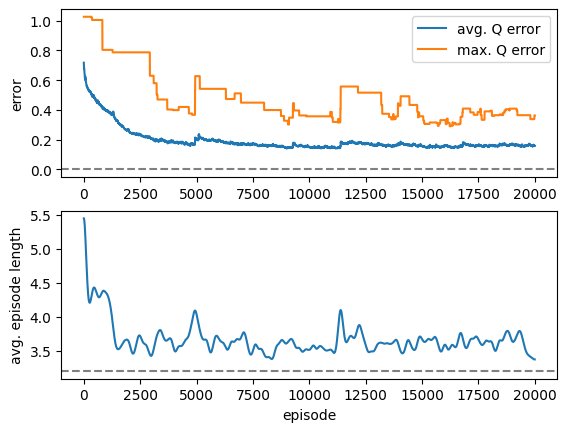

In [16]:
# policy, based on Q
def epsilon_greedy_Q_policy(s, Q, eps=0.1):
    if np.random.uniform(0, 1) <= eps:
        return np.random.choice(np.arange(4))
    # Random sample from all equally optimal options
    return np.random.choice(np.where(Q[tuple(s)]==np.max(Q[tuple(s)]))[0])
# parameters
total_episodes = 20000
max_steps_pr_episode = 100
gamma = 0.9
alpha = 0.2
target = (3,3)
# Initialize Q.
Q_pi_hat = np.zeros((4, 4, 4))
# Lists to keep track of training statistics.
episode_lengths = []
max_errors = []
avg_errors = []
env = GridWorldEnv()
for episode in range(total_episodes):
    s = env.reset(target=target)[0]['agent']
    step = 0
    # Lists collected for each trajectory.
    states = []
    actions = []
    rewards = []
    # Generate a trajectory for a limited number of steps.
    while step<max_steps_pr_episode:
        step += 1
        states.append(s)
        a = epsilon_greedy_Q_policy(s, Q_pi_hat)  # Pick action.
        actions.append(a)
        next_s, r, terminal, _ = env.step(a)  # Take a step in the environment.
        next_s = next_s['agent']
        rewards.append(r)
        s = next_s
        if terminal: # the episode is over
            break
    # Update the Q-values based on the rewards received by traversing the
    # trajectory in reverse order.
    episode_lengths.append(float(step))
    G = 0  # Accumulated returns.
    step -= 1
    while step >= 0:
        G = gamma * G + rewards[-1]
        rewards = rewards[:-1]
        s = states[-1]
        states = states[:-1]
        a = actions[-1]
        actions = actions[:-1]
        # We only update Q(s, a) for the first occurence of the pair in the trajectory.
        update_q = True
        for i in range(len(states)):
            if (s == states[i]).all() and a == actions[i]:
                update_q = False
                break
        if update_q:
            # update the Q-function with the new episode
            Q_pi_hat[tuple(s)][a] = (1-alpha)*Q_pi_hat[tuple(s)][a] + alpha * G
        step -= 1
    # metrics for plotting
    max_errors.append(np.max(np.abs(Q_star - Q_pi_hat)))
    avg_errors.append(np.mean(np.abs(Q_star - Q_pi_hat)))

# plotting
fig, [ax1,ax2] = plt.subplots(2,1)
ax1.plot(avg_errors,label='avg. Q error')
ax1.plot(max_errors, label='max. Q error')
ax1.axhline(0,c='grey',linestyle='--')
ax1.set_ylabel('error')
ax1.legend()
ax2.plot(gaussian_filter(episode_lengths,100))
opt_avg_eps_length = 1/15*(2*1+3*2+4*3+3*4+2*5+1*6)
ax2.axhline(opt_avg_eps_length, c='grey', linestyle='--')
ax2.set_xlabel('episode')
ax2.set_ylabel('avg. episode length')

### Tasks:
1. What would happen if we computed our value functions by simply averagng over trial runs $V^\pi(s) \approx \frac{1}{N(s)} \sum_{i=1}^{N(s)} G_i$?
2. Does the error between $Q^*$ and $\hat{Q}^\pi$ go to zero? Why?
3. Does the average episode length converge to its optimum? Why?

 **Q: What would happen if we computed our value functions by simply averagng over trial runs  Vπ(s)≈(1/N(s))∑ goes from i=1 to N(s) * Gi ?**

Ans:  Simple averaging over trial runs estimates
𝑉𝜋(
𝑠
)
 for the policy
𝜋
π used during sampling (e.g.,
𝜖
ϵ-greedy). However:

- It reflects the value of the current policy
𝜋, not the optimal policy
𝑉
∗
 , unless
𝜋
π converges to
𝜋
∗
 .
With an
ϵ-greedy policy, the estimate includes returns from exploratory (random) actions, leading to suboptimal values compared to
𝑉
∗.

- Convergence requires many samples per state (
𝑁
(
𝑠
)
→
∞
N(s)→∞), and variance in returns can slow convergence, especially in states rarely visited.


**Simple averaging gives
𝑉
𝜋
 , not
𝑉
∗
 , due to the suboptimal
ϵ-greedy policy and exploration.**

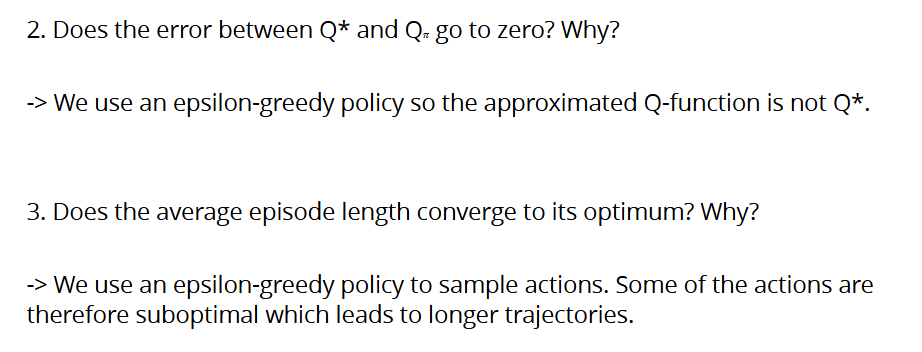

# Q-Learning
A popular reinforcement learning algorihtm is Q-learning. It combines the iterative nature of dynamic programming with the sample-based learning approach of Monte Carlo methods. This process resembles dynamic programming's iterative refinement of value functions. However, Q-learning diverges by employing sample-based updates akin to Monte Carlo simulation, where experiences from interactions with the environment inform the value estimates.

The update rule for Q-Learning is:

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( r_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \right)$

This update rule iteratively refines the Q-values, gradually converging towards the optimal Q-values that correspond to the optimal policy. Note that, in contrast to the update equation from Monte-Carlo methods, the update equation for Q-learning has no dependance on the policy that was used to collect the data. This means that we can learn the optimal policy from data that was collected using any different policy, as long as it visits all state-action pairs often enough.

Text(0, 0.5, 'avg. episode length')

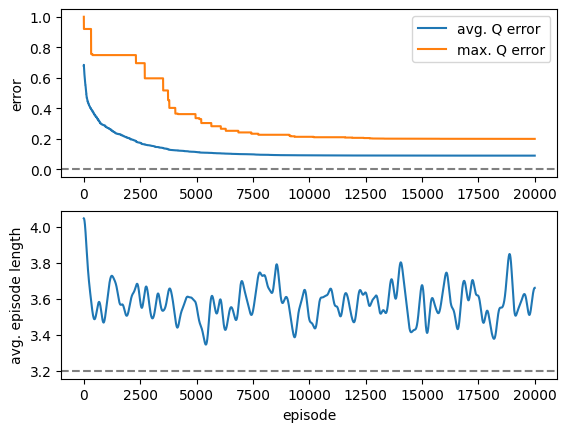

In [17]:
## Main
# policy, based on Q
def epsilon_greedy_Q_policy(s, Q, eps=0.1):
    if np.random.uniform(0, 1) <= eps:
        return np.random.choice(np.arange(4))
    # Random sample from all equally optimal options
    return np.random.choice(np.where(Q[tuple(s)]==np.max(Q[tuple(s)]))[0])
# parameters
total_episodes = 20000
max_steps_per_episode = 100
gamma = 0.9
alpha = 0.2
target = (3,3)
# Initialize Q.
Q_pi_hat = np.zeros((4, 4, 4))
# Lists to keep track of training statistics.
episode_lengths = []
max_errors = []
avg_errors = []
env = GridWorldEnv()
for episode in range(total_episodes):
    s = env.reset(target=target)[0]['agent']
    step = 0
    # Generate a trajectory for a limited number of steps.
    while step<max_steps_per_episode:
        step += 1
        a = epsilon_greedy_Q_policy(s, Q_pi_hat)  # Pick action.
        next_s, r, terminal, _ = env.step(a)  # Take a step in the environment.
        next_s = next_s["agent"]
        ####################
		## Your code here ##
        delta = r + gamma * max(Q_pi_hat[tuple(next_s)]) - Q_pi_hat[tuple(s)][a]
        Q_pi_hat[tuple(s)][a] += alpha * delta  # Q-learning update.
  		####################
        s = next_s
        if terminal:
            break
    ## metrics for plotting
    episode_lengths.append(float(step))
    max_errors.append(np.max(np.abs(Q_star - Q_pi_hat)))
    avg_errors.append(np.mean(np.abs(Q_star - Q_pi_hat)))

# plotting
fig, [ax1,ax2] = plt.subplots(2,1)
ax1.plot(avg_errors,label='avg. Q error')
ax1.plot(max_errors, label='max. Q error')
ax1.axhline(0,c='grey',linestyle='--')
ax1.set_ylabel('error')
ax1.legend()
ax2.plot(gaussian_filter(episode_lengths,100))
opt_avg_eps_length = 1/15*(2*1+3*2+4*3+3*4+2*5+1*6)
ax2.axhline(opt_avg_eps_length, c='grey', linestyle='--')
ax2.set_xlabel('episode')
ax2.set_ylabel('avg. episode length')

### Tasks:
1. Code the Q-Learning update-equation n the cell above.
2. Does the error between $Q^*$ and $\hat{Q}^\pi$ go to zero? Why?
3. Does the average episode length converge to its optimum? Why?

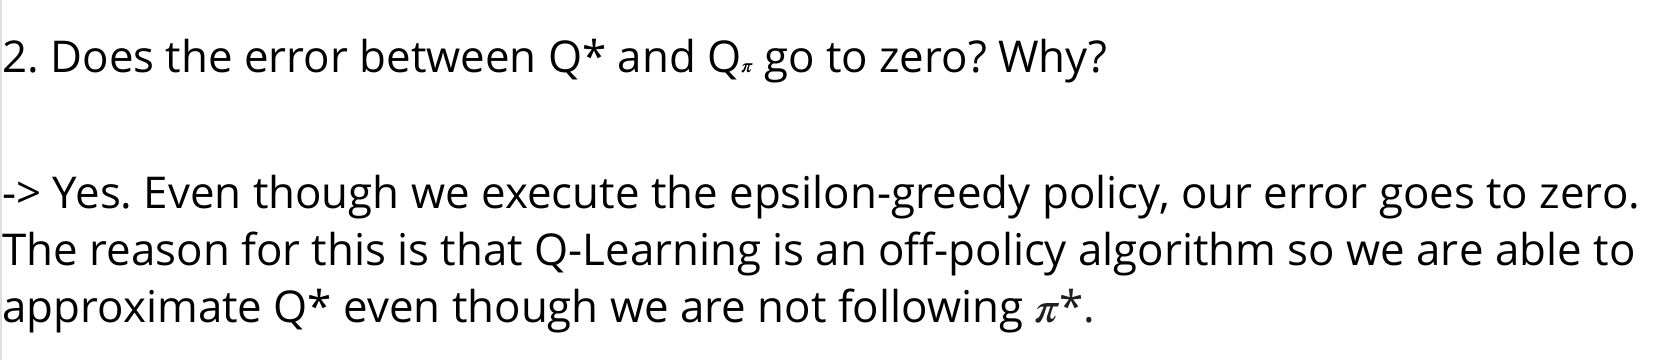

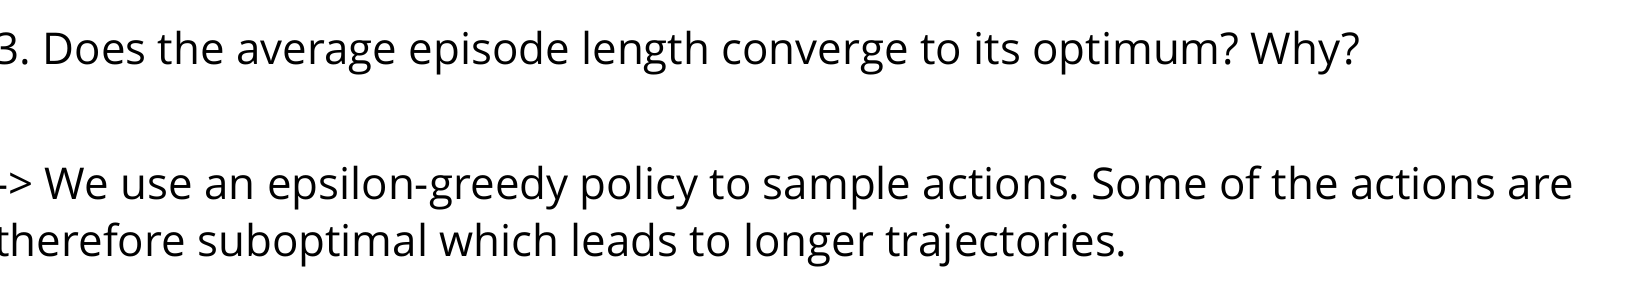